In [3]:
import numpy as np
import pandas as pd
import datetime
import re
from dateutil.parser import parse
import glob
import sys
import openpyxl as opx
import xlrd
import seaborn as sns
import random
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import font_manager, rc
matplotlib.rcParams['axes.unicode_minus'] = False
font_path = "C:/Windows/Fonts/malgun.TTF"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)
%matplotlib inline

import torch.nn as nn
import torch.optim as optim
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# kepsh1 데이터 로딩
- 210601~ 220729 데이터

In [4]:
df = pd.read_csv('./data/220729/220729 kepsh1.csv', parse_dates = True, encoding = 'unicode_escape')

In [5]:
df['DateTime']= pd.to_datetime(df['DateTime'])

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 572862 entries, 0 to 572861
Data columns (total 27 columns):
 #   Column                            Non-Null Count   Dtype         
---  ------                            --------------   -----         
 0   DateTime                          572862 non-null  datetime64[ns]
 1   Room_Temp(°C)                     572489 non-null  float64       
 2   T1(°C)                            572489 non-null  float64       
 3   T2(°C)                            572489 non-null  float64       
 4   T3(°C)                            572489 non-null  float64       
 5   T4(°C)                            572489 non-null  float64       
 6   T5(°C)                            572489 non-null  float64       
 7   T6(°C)                            572489 non-null  float64       
 8   T7(°C)                            572489 non-null  float64       
 9   T8(°C)                            572489 non-null  float64       
 10  T9(°C)                          

In [7]:
df = df.set_index('DateTime')

In [8]:
# 이상치 제거 (Room Temp가 5oC 이하인경우: 데이터 끊긴것으로 간주)
df= df[df['Room_Temp(°C)']>=5]

In [9]:
# HP 부하 정리 
df.loc[(df['F1(lpm)'] > 1) & (df['F2(lpm)'] > 1), 'Heatpump_Load(W)'] = df['Heatpump_Load(W)'] - 292 - 110
df.loc[(df['F2(lpm)'] < 1) & (df['F2(lpm)'] < 1), 'Heatpump_Load(W)'] = df['Heatpump_Load(W)'] - 29
df.loc[df['F2(lpm)'] > 1, 'Heatpump_Load(W)'] = df['Heatpump_Load(W)'] - 110
df.loc[df['F1(lpm)'] > 1, 'Heatpump_Load(W)'] = df['Heatpump_Load(W)'] - 292

In [10]:
# 열량계산
df.loc[(df['F3(lpm)'] > 0.5) & (df['RoomCon_Mode'] == 0), 'Qgen_heat(W)'] = (df['T3(°C)'] - df['T4(°C)']) * 4.19 * df['F3(lpm)'] * 1000/60
df.loc[(df['F3(lpm)'] > 0.5) & (df['RoomCon_Mode'] == 1), 'Qgen_cool(W)'] = (df['T4(°C)'] - df['T3(°C)']) * 4.19 * df['F3(lpm)'] * 1000/60

In [11]:
#PVT생산열 계산 
df.loc[(df['F1(lpm)'] > 0.5) & (df['T2(°C)'] != 0), 'Qpvt(W)'] = (df['T1(°C)'] - df['T2(°C)']) * 4.19 * df['F1(lpm)'] * 1000/60

In [12]:
# PVT전력 이상치제거
df.loc[df['Pvt_Supply(W)'] < -15, 'Pvt_Supply(W)'] = 0

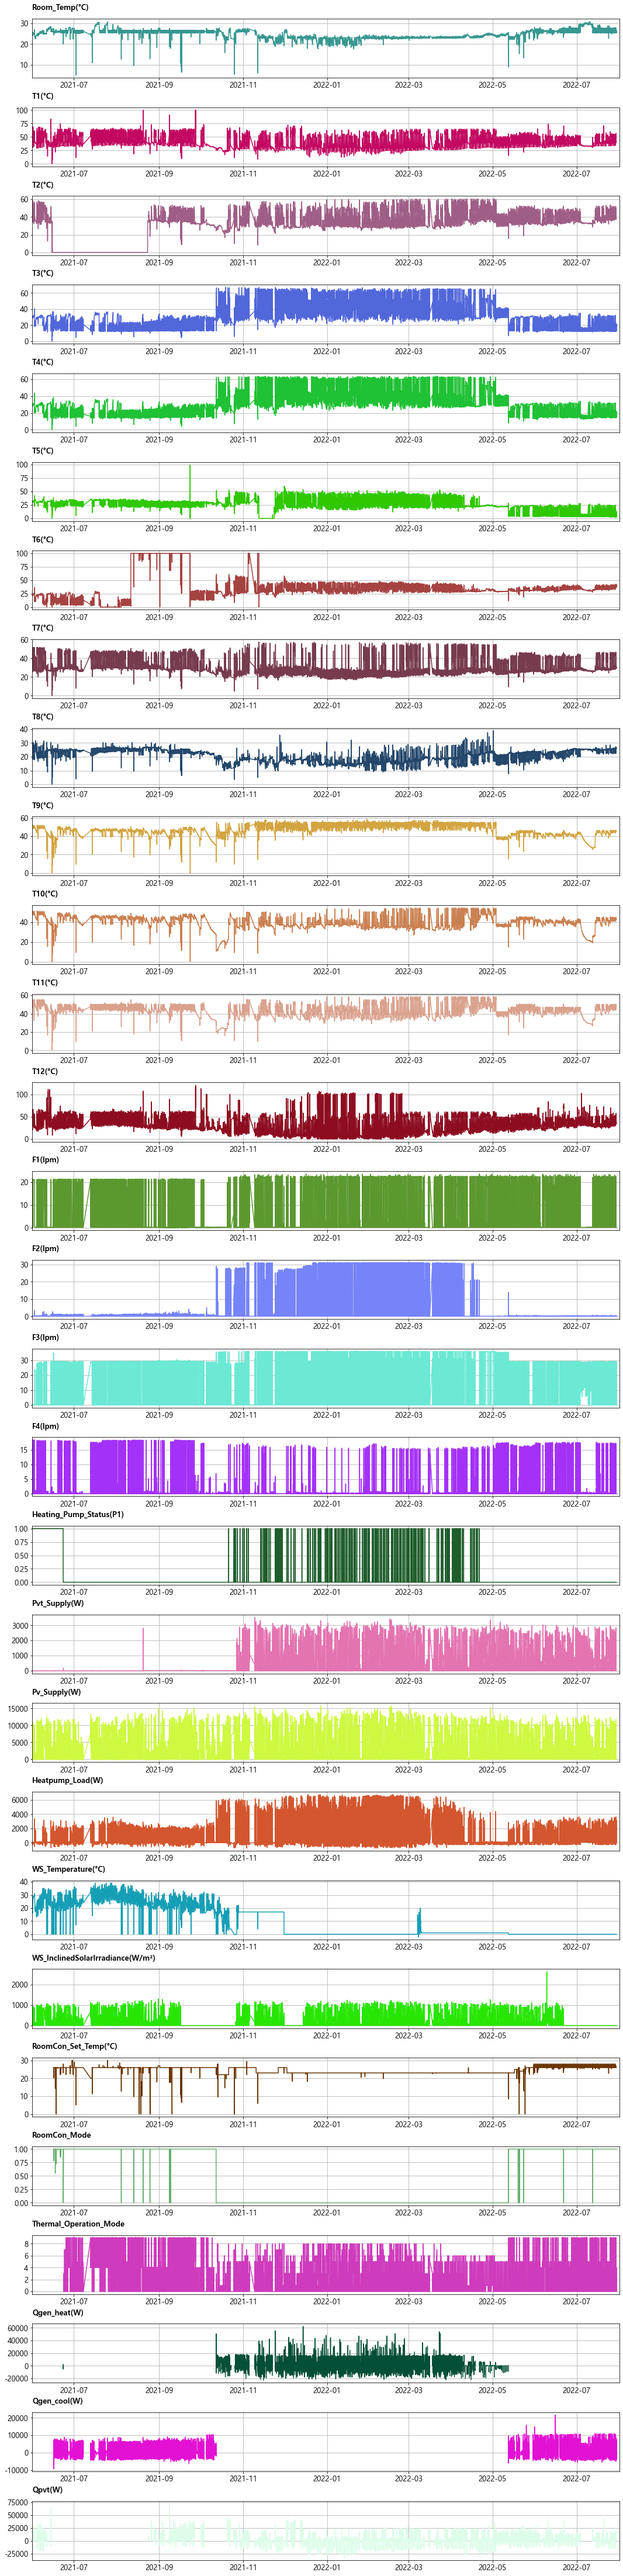

In [13]:
fig, ax = plt.subplots(figsize=(18,80))

for i in range(len(df.columns)):
    plt.subplot(len(df.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.5)
    name = df.columns[i]
    r=random.random()
    g=random.random()
    b=random.random()
    color=(r,g,b)
    plt.plot(df.index, df[name], color=color)    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-06-01'), pd.Timestamp('2022-08-01'))    
    plt.grid(True)
plt.show()
fig.tight_layout()

In [14]:
df_ashp = df[['Pv_Supply(W)', 'Pvt_Supply(W)', 'Qpvt(W)', 'Heatpump_Load(W)', 'Qgen_heat(W)', 'Qgen_cool(W)']]

In [15]:
df_ashp

,Pv_Supply(W),Pvt_Supply(W),Qpvt(W),Heatpump_Load(W),Qgen_heat(W),Qgen_cool(W)
DateTime,,,,,,
2022-07-29 21:38:00,-49.0,-9.0,NaN,-1.0,NaN,NaN
2022-07-29 21:37:00,-49.0,-9.0,NaN,-1.0,NaN,NaN
2022-07-29 21:36:00,-49.0,-9.0,NaN,0.0,NaN,NaN
2022-07-29 21:35:00,-49.0,-9.0,NaN,0.0,NaN,NaN
2022-07-29 21:34:00,-49.0,-9.0,NaN,5.0,NaN,NaN
...,...,...,...,...,...,...
2021-06-01 00:04:00,-50.0,-9.0,NaN,0.0,NaN,NaN
2021-06-01 00:03:00,-50.0,-9.0,NaN,1.0,NaN,NaN
2021-06-01 00:02:00,-50.0,-9.0,NaN,0.0,NaN,NaN


# 1시간 단위 분석

In [16]:
df_ashp_1h = df_ashp.resample('1h').sum()/60/1000

In [17]:
df_ashp_1h = df_ashp_1h.rename(columns={'Heatpump_Load(W)':'Heatpump_Load(kWh)',
                                        'Qgen_heat(W)':'Qgen_heat(kWh)',
                                        'Qgen_cool(W)':'Qgen_cool(kWh)',
                                        'Pv_Supply(W)':'Pv_Supply(kWh)',
                                        'Pvt_Supply(W)':'Pvt_Supply(kWh)',
                                        'Qpvt(W)':'Qpvt(kWh)'})

In [18]:
df_ashp_1h['Heating_COP'] = df_ashp_1h['Qgen_heat(kWh)'] / df_ashp_1h['Heatpump_Load(kWh)']
df_ashp_1h['Cooling_COP'] = df_ashp_1h['Qgen_cool(kWh)'] / df_ashp_1h['Heatpump_Load(kWh)']

In [19]:
df_ashp_1h = df_ashp_1h[df_ashp_1h['Heating_COP']<5]
df_ashp_1h = df_ashp_1h[df_ashp_1h['Cooling_COP']<5]
df_ashp_1h = df_ashp_1h[df_ashp_1h['Heating_COP']>=0]
df_ashp_1h = df_ashp_1h[df_ashp_1h['Cooling_COP']>=0]
# df_ashp_1h = df_ashp_1h[df_ashp_1h['Pvt_Supply(kWh)']>-0.1]

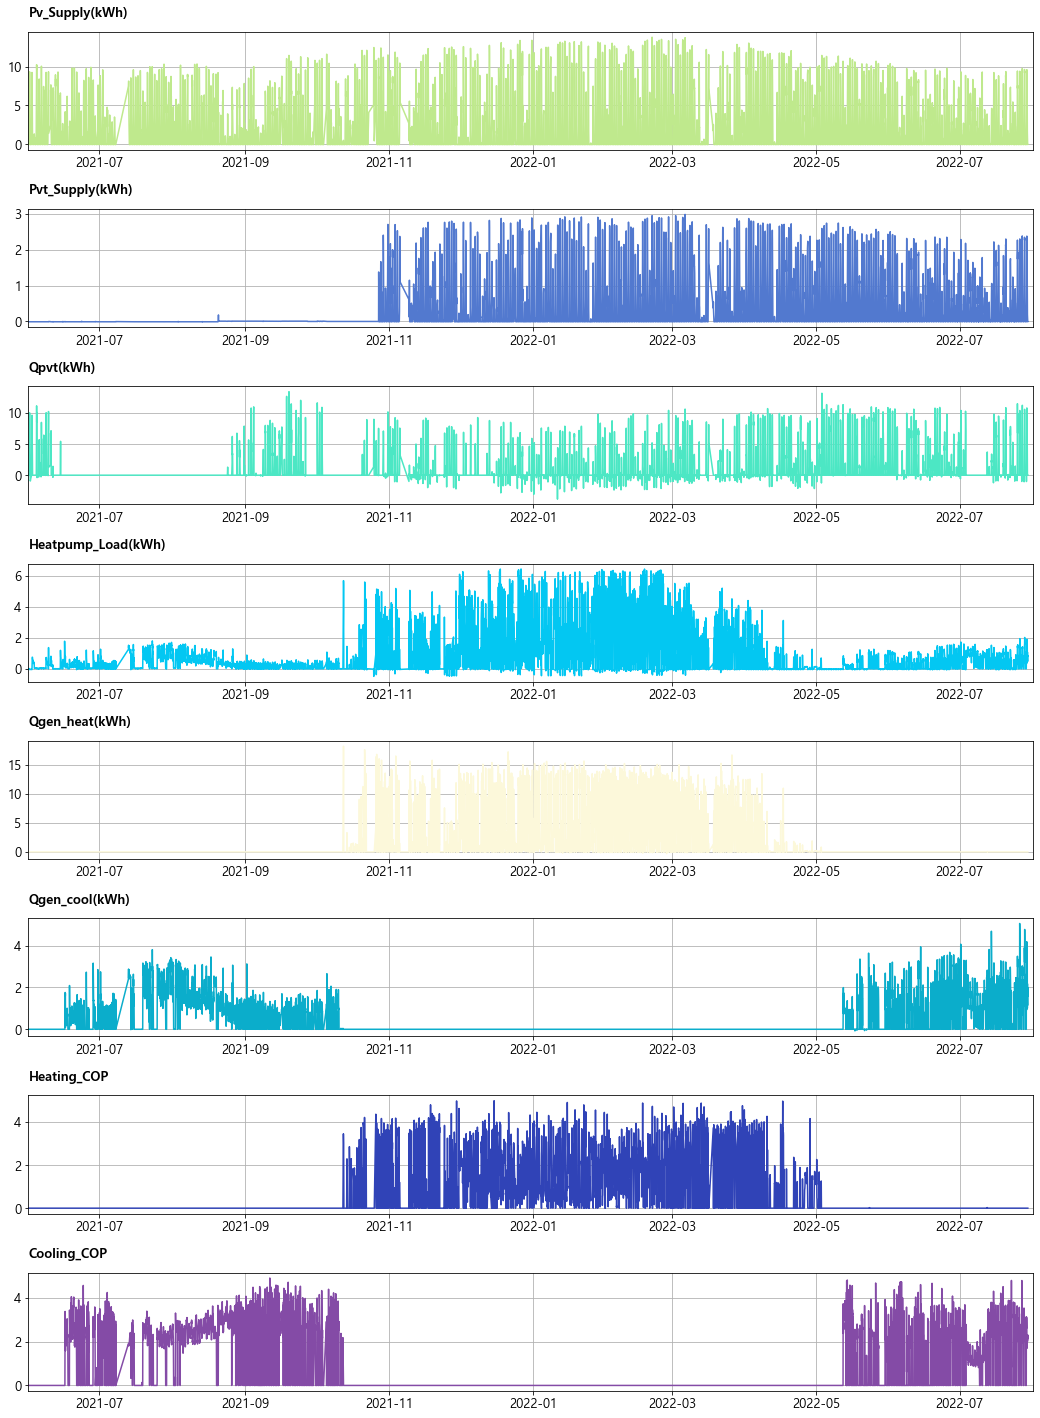

In [20]:
fig, ax = plt.subplots(figsize=(18,25))

for i in range(len(df_ashp_1h.columns)):
    plt.subplot(len(df_ashp_1h.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.5)
    name = df_ashp_1h.columns[i]
    r=random.random()
    g=random.random()
    b=random.random()
    color=(r,g,b)
    plt.plot(df_ashp_1h.index, df_ashp_1h[name], color=color)    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-06-01'), pd.Timestamp('2022-08-01'))    
    plt.grid(True)
plt.show()
fig.tight_layout()

# 1일단위 분석 

In [21]:
df_ashp_1d = df_ashp.resample('1d').sum()/60/1000

In [22]:
df_ashp_1d = df_ashp_1d.rename(columns={'Heatpump_Load(W)':'Heatpump_Load(kWh)',
                                        'Qgen_heat(W)':'Qgen_heat(kWh)',
                                        'Qgen_cool(W)':'Qgen_cool(kWh)',
                                        'Pv_Supply(W)':'Pv_Supply(kWh)',
                                        'Pvt_Supply(W)':'Pvt_Supply(kWh)',
                                        'Qpvt(W)':'Qpvt(kWh)'})

In [23]:
df_ashp_1d['Heating_COP'] = df_ashp_1d['Qgen_heat(kWh)'] / df_ashp_1d['Heatpump_Load(kWh)']
df_ashp_1d['Cooling_COP'] = df_ashp_1d['Qgen_cool(kWh)'] / df_ashp_1d['Heatpump_Load(kWh)']

In [24]:
df_ashp_1d = df_ashp_1d[df_ashp_1d['Heating_COP']<5]
df_ashp_1d = df_ashp_1d[df_ashp_1d['Cooling_COP']<5]
df_ashp_1d = df_ashp_1d[df_ashp_1d['Heating_COP']>=0]
df_ashp_1d = df_ashp_1d[df_ashp_1d['Cooling_COP']>=0]
# df_ashp_1d = df_ashp_1d[df_ashp_1d['Pvt_Supply(kWh)']>-0.1]

In [25]:
df_ashp_1d.describe()

,Pv_Supply(kWh),Pvt_Supply(kWh),Qpvt(kWh),Heatpump_Load(kWh),Qgen_heat(kWh),Qgen_cool(kWh),Heating_COP,Cooling_COP
count,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000,402.000000
mean,48.904915,7.704125,18.759146,15.211126,27.184469,9.111810,1.188799,1.193221
std,22.545512,6.811571,19.106858,15.095492,38.108620,13.438514,1.315386,1.402209
min,-0.246983,-0.229817,-1.917836,-1.523667,-0.642007,-0.078281,0.000000,-0.000000
25%,30.830896,0.136088,0.000000,3.850233,0.000000,0.000000,0.000000,0.000000
50%,53.099667,7.797175,13.791912,10.071275,0.000000,0.000000,0.000000,0.000000
75%,65.974479,14.491487,34.005968,22.175450,54.798704,14.428590,2.364322,2.576784
max,90.650250,18.469717,66.949262,75.367633,148.223714,73.366762,3.925224,4.570071


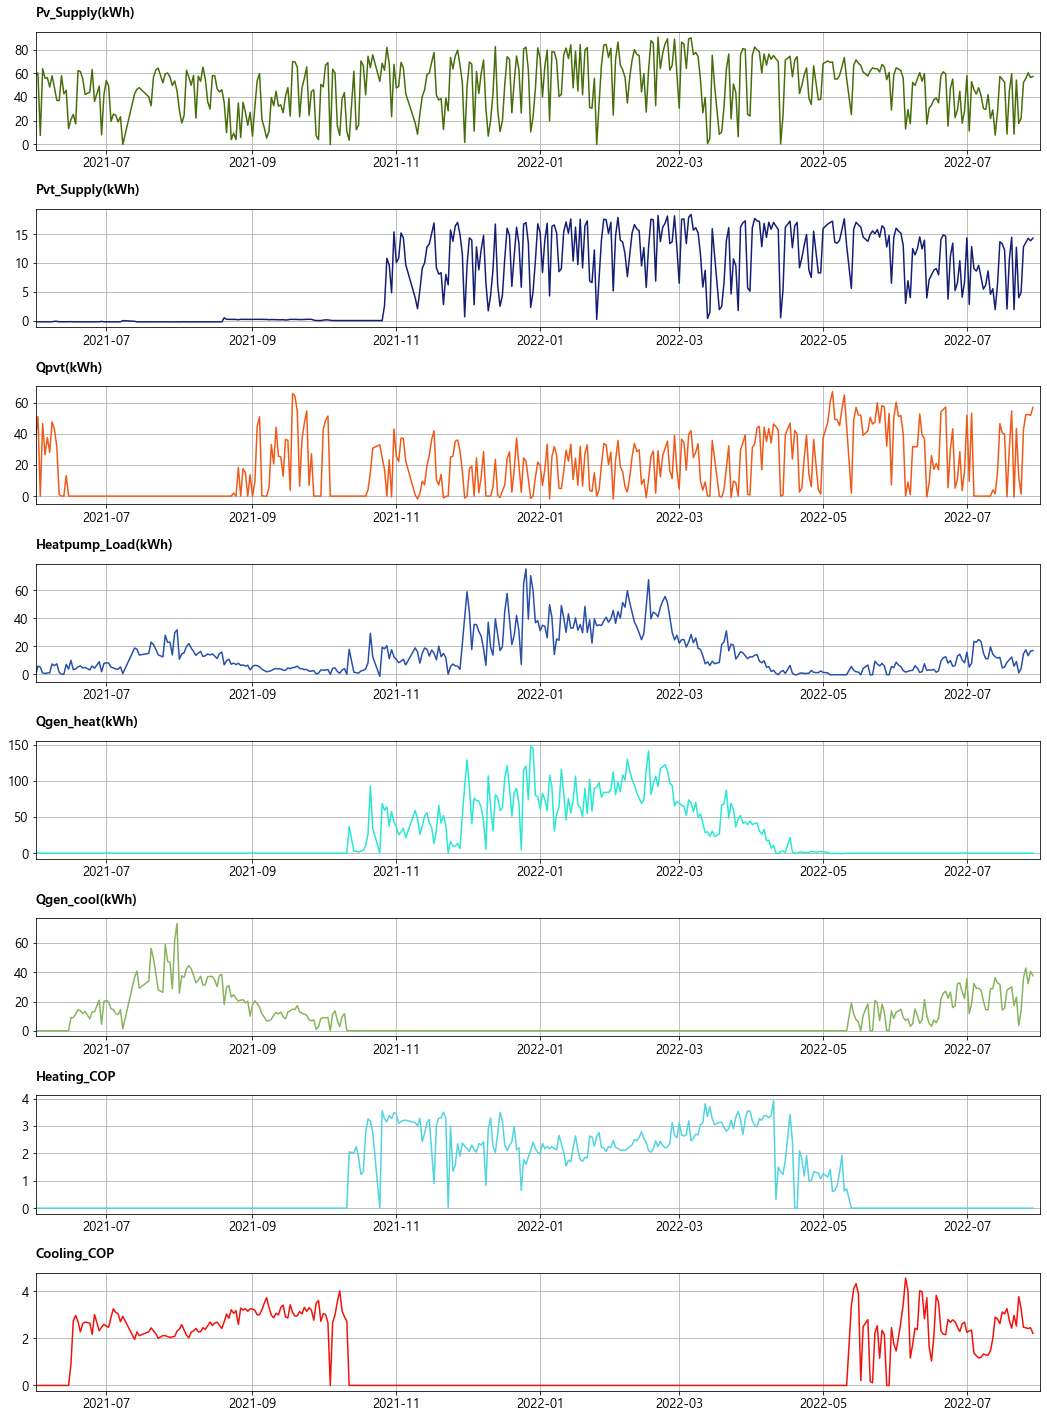

In [26]:
fig, ax = plt.subplots(figsize=(18,25))

for i in range(len(df_ashp_1d.columns)):
    plt.subplot(len(df_ashp_1d.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.5)
    name = df_ashp_1d.columns[i]
    r=random.random()
    g=random.random()
    b=random.random()
    color=(r,g,b)
    plt.plot(df_ashp_1d.index, df_ashp_1d[name], color=color)    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-06-01'), pd.Timestamp('2022-08-01'))    
    plt.grid(True)
plt.show()
fig.tight_layout()

In [27]:
df_ashp_1d.loc['2022-01']

,Pv_Supply(kWh),Pvt_Supply(kWh),Qpvt(kWh),Heatpump_Load(kWh),Qgen_heat(kWh),Qgen_cool(kWh),Heating_COP,Cooling_COP
DateTime,,,,,,,,
2022-01-01,72.567767,15.306383,19.783155,31.162983,61.419967,0.0,1.970927,0.0
2022-01-02,40.035383,8.364567,6.912451,35.037317,82.883156,0.0,2.365568,0.0
2022-01-03,66.116917,14.032233,17.209659,34.306600,74.417628,0.0,2.169193,0.0
2022-01-04,79.709683,16.932483,33.390542,26.083800,58.809337,0.0,2.254631,0.0
2022-01-05,19.987333,4.273283,-1.721569,49.847717,108.012771,0.0,2.166855,0.0
2022-01-06,78.206983,16.388267,25.280324,40.693233,91.922317,0.0,2.258909,0.0
2022-01-07,78.187783,16.631117,31.735683,14.207333,30.788629,0.0,2.167094,0.0
2022-01-08,70.770200,15.234950,26.311830,25.321000,54.155058,0.0,2.138741,0.0
2022-01-09,40.418417,8.508783,5.092817,24.271950,64.441819,0.0,2.654991,0.0


# 1주단위 분석

In [28]:
df_ashp_1W = df_ashp.resample('1W').sum()/60/1000

In [29]:
df_ashp_1W = df_ashp_1W.rename(columns={'Heatpump_Load(W)':'Heatpump_Load(kWh)',
                                        'Qgen_heat(W)':'Qgen_heat(kWh)',
                                        'Qgen_cool(W)':'Qgen_cool(kWh)',
                                        'Pv_Supply(W)':'Pv_Supply(kWh)',
                                        'Pvt_Supply(W)':'Pvt_Supply(kWh)',
                                        'Qpvt(W)':'Qpvt(kWh)'})

In [30]:
df_ashp_1W['Heating_COP'] = df_ashp_1W['Qgen_heat(kWh)'] / df_ashp_1W['Heatpump_Load(kWh)']
df_ashp_1W['Cooling_COP'] = df_ashp_1W['Qgen_cool(kWh)'] / df_ashp_1W['Heatpump_Load(kWh)']

In [31]:
df_ashp_1W['2021-06' : ' 2021-12']

,Pv_Supply(kWh),Pvt_Supply(kWh),Qpvt(kWh),Heatpump_Load(kWh),Qgen_heat(kWh),Qgen_cool(kWh),Heating_COP,Cooling_COP
DateTime,,,,,,,,
2021-06-06,302.139133,-1.303000,199.102264,12.693183,0.000000,0.000000,0.000000,0.000000
2021-06-13,329.284083,-1.351533,151.428927,23.420867,0.000000,0.000000,0.000000,0.000000
2021-06-20,246.411600,-1.501433,13.153194,39.161983,0.000000,57.536130,0.000000,1.469183
2021-06-27,312.405500,-1.492883,0.000000,25.544217,-0.835938,65.639056,-0.032725,2.569625
2021-07-04,247.508233,-1.492567,0.000000,44.391200,0.000000,115.579408,0.000000,2.603656
2021-07-11,66.776333,-0.691850,0.000000,13.215600,0.000000,38.661356,0.000000,2.925433
2021-07-18,293.635650,-1.253900,0.000000,53.219683,0.000000,106.456159,0.000000,2.000316
2021-07-25,361.477067,-1.592550,0.000000,104.302067,0.000000,233.247586,0.000000,2.236270
2021-08-01,354.334650,-1.591783,0.000000,159.815267,0.000000,343.009931,0.000000,2.146290


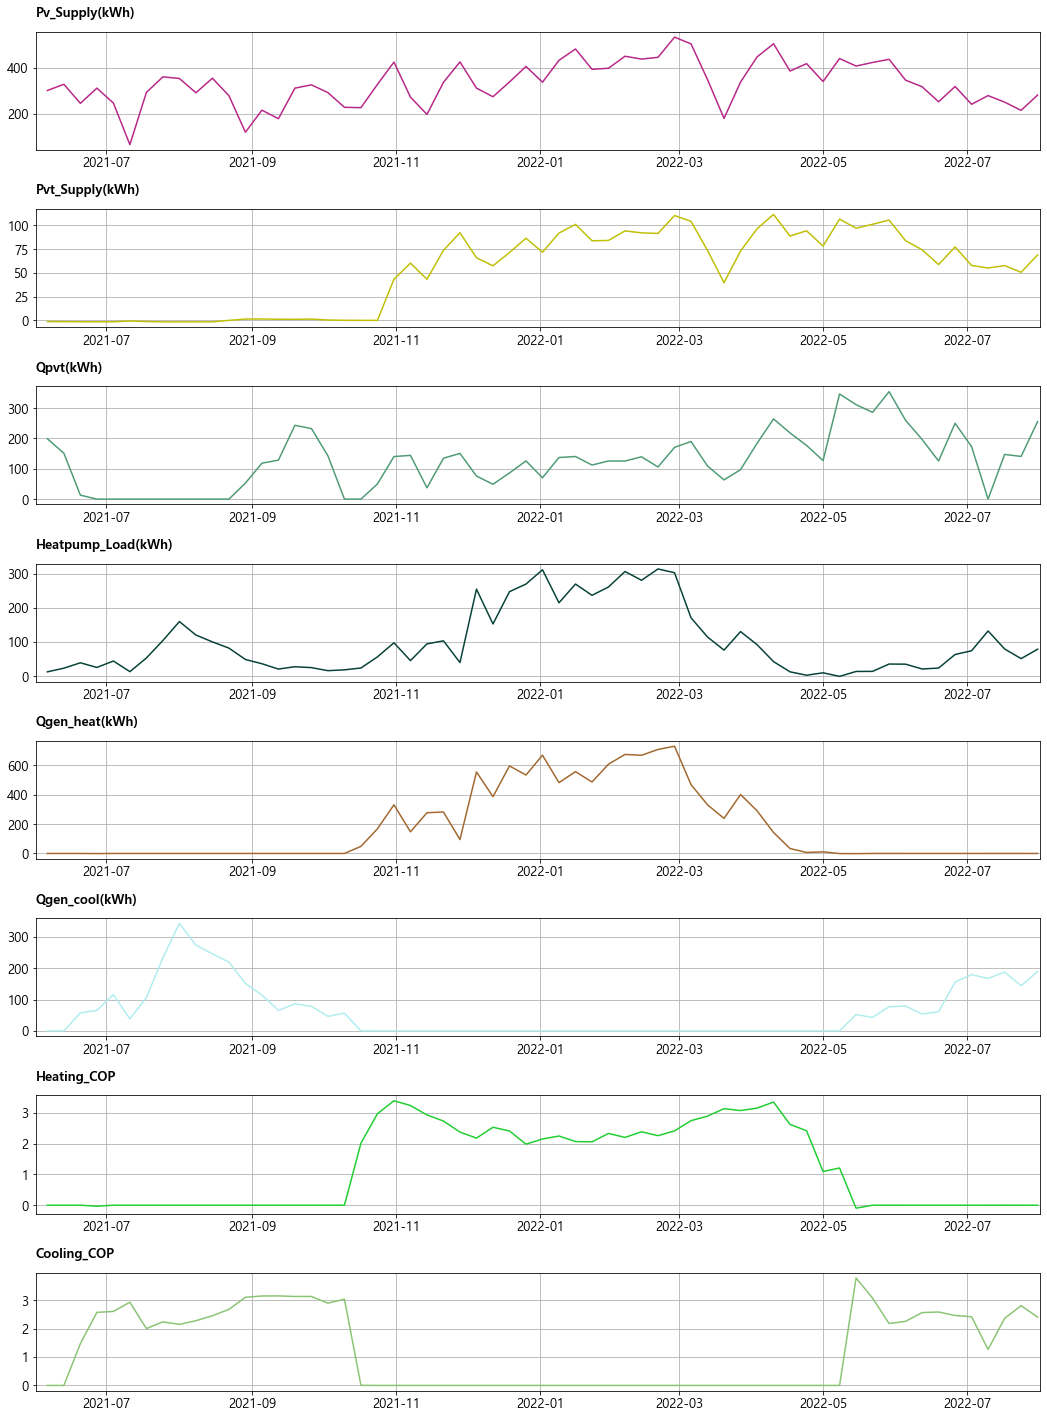

In [32]:
fig, ax = plt.subplots(figsize=(18,25))

for i in range(len(df_ashp_1W.columns)):
    plt.subplot(len(df_ashp_1W.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.5)
    name = df_ashp_1W.columns[i]
    r=random.random()
    g=random.random()
    b=random.random()
    color=(r,g,b)
    plt.plot(df_ashp_1W.index, df_ashp_1W[name], color=color)    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-06-01'), pd.Timestamp('2022-08-01'))    
    plt.grid(True)
plt.show()
fig.tight_layout()

# 1달 단위 분석

In [33]:
df_ashp_1M = df_ashp.resample('1M').sum()/60/1000

In [34]:
df_ashp_1M = df_ashp_1M.rename(columns={'Heatpump_Load(W)':'Heatpump_Load(kWh)',
                                        'Qgen_heat(W)':'Qgen_heat(kWh)',
                                        'Qgen_cool(W)':'Qgen_cool(kWh)',
                                        'Pv_Supply(W)':'Pv_Supply(kWh)',
                                        'Pvt_Supply(W)':'Pvt_Supply(kWh)',
                                        'Qpvt(W)':'Qpvt(kWh)'})

In [35]:
df_ashp_1M['Heating_COP'] = df_ashp_1M['Qgen_heat(kWh)'] / df_ashp_1M['Heatpump_Load(kWh)']
df_ashp_1M['Cooling_COP'] = df_ashp_1M['Qgen_cool(kWh)'] / df_ashp_1M['Heatpump_Load(kWh)']

In [36]:
df_ashp_1M

,Pv_Supply(kWh),Pvt_Supply(kWh),Qpvt(kWh),Heatpump_Load(kWh),Qgen_heat(kWh),Qgen_cool(kWh),Heating_COP,Cooling_COP
DateTime,,,,,,,,
2021-06-30,1289.559350,-6.248650,363.684385,119.339683,-0.835938,168.656160,-0.007005,1.413245
2021-07-31,1195.555883,-5.799467,0.000000,345.623633,0.000000,765.598043,0.000000,2.215121
2021-08-31,1120.217150,-1.645617,66.573727,372.137633,0.000000,947.556878,0.000000,2.546254
2021-09-30,1100.104367,4.715950,709.703804,107.288783,0.000000,334.453375,0.000000,3.117319
2021-10-31,1395.655333,43.696750,333.262441,206.120717,547.880371,83.366853,2.658056,0.404456
2021-11-30,1289.592067,281.946233,482.230313,346.056217,946.425347,0.000000,2.734889,0.000000
2021-12-31,1505.324633,317.219200,366.456112,1106.993783,2453.781915,0.000000,2.216618,0.000000
2022-01-31,1903.218550,401.952367,570.996249,1087.903750,2367.391461,0.000000,2.176104,0.000000
2022-02-28,1849.060033,383.936117,530.349504,1191.599633,2767.083955,0.000000,2.322159,0.000000


In [ ]:
df = df.set_index('DateTime')

In [ ]:
fig, ax = plt.subplots(figsize=(18,80))

for i in range(len(df.columns)):
    plt.subplot(len(df.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.5)
    name = df.columns[i]
    r=random.random()
    g=random.random()
    b=random.random()
    color=(r,g,b)
    plt.plot(df[name], color=color)    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-06-01'), pd.Timestamp('2022-08-01'))    
    plt.grid(True)
plt.show()
fig.tight_layout()

In [ ]:
df['GSHP_inputE(We)'] = df['Grid2GSHP(We)'] + df['ESS2GSHP(We)']

In [ ]:
df_gshp = df[['DateTime', 'GSHP_inputE(We)', 'GSHP2CTES(Wt)', 'CTES2Cool(Wt)', 'GSHP2HTES(Wt)', 'HTES2Heat(Wt)']]

In [ ]:
df_gshp = df_gshp.set_index('DateTime')

In [ ]:
df_gshp_1d = df_gshp.resample('1d').sum()/60/1000

In [ ]:
df_gshp_1d = df_gshp_1d.rename(columns={'GSHP_inputE(We)':'GSHP_inputE(kWh)',
                                        'GSHP2CTES(Wt)':'GSHP2CTES(kWh)',
                                        'CTES2Cool(Wt)':'CTESCool(kWh)',
                                        'GSHP2HTES(Wt)':'GSHP2HTES(kWh)',
                                        'HTES2Heat(Wt)':'HTES2Heat(kWh)'})

In [ ]:
df_gshp_1d

In [ ]:
df_gshp_1d['Cooling_COP'] = df_gshp_1d['GSHP2CTES(kWh)'] / df_gshp_1d['GSHP_inputE(kWh)']
df_gshp_1d['Heating_COP'] = df_gshp_1d['GSHP2HTES(kWh)'] / df_gshp_1d['GSHP_inputE(kWh)']
df_gshp_1d['Heating_COP_load'] = df_gshp_1d['HTES2Heat(kWh)'] / df_gshp_1d['GSHP_inputE(kWh)'] # COP값이상해서 HTES2Heat로 대체

In [ ]:
df_gshp_1d.loc['2022-05-01':'2022-06-15']

In [ ]:
df_gshp_1d.loc['2021-11-01':'2021-11-30']

In [ ]:
df_gshp_1d.loc['2022-07-01':'2022-07-31']

# 1시간단위로 분석

In [ ]:
df_gshp_1h = df_gshp.resample('1h').sum()/60/1000

In [ ]:
df_gshp_1h = df_gshp_1h.rename(columns={'GSHP_inputE(We)':'GSHP_inputE(kWh)',
                                        'GSHP2CTES(Wt)':'GSHP2CTES(kWh)',
                                        'CTES2Cool(Wt)':'CTESCool(kWh)',
                                        'GSHP2HTES(Wt)':'GSHP2HTES(kWh)',
                                        'HTES2Heat(Wt)':'HTES2Heat(kWh)'})

In [ ]:
df_gshp_1h

In [ ]:
df_gshp_1h['Cooling_COP'] = df_gshp_1h['GSHP2CTES(kWh)'] / df_gshp_1h['GSHP_inputE(kWh)']
df_gshp_1h['Heating_COP'] = df_gshp_1h['GSHP2HTES(kWh)'] / df_gshp_1h['GSHP_inputE(kWh)']
df_gshp_1h['Heating_COP_load'] = df_gshp_1h['HTES2Heat(kWh)'] / df_gshp_1h['GSHP_inputE(kWh)']

In [ ]:
df_gshp_1h.loc['2022-07-27':'2022-07-28']

# 1달단위로 분석

In [ ]:
df_gshp_1M = df_gshp.resample('1M').sum()/60/1000

In [ ]:
df_gshp_1M = df_gshp_1M.rename(columns={'GSHP_inputE(We)':'GSHP_inputE(kWh)',
                                        'GSHP2CTES(Wt)':'GSHP2CTES(kWh)',
                                        'CTES2Cool(Wt)':'CTESCool(kWh)',
                                        'GSHP2HTES(Wt)':'GSHP2HTES(kWh)',
                                        'HTES2Heat(Wt)':'HTES2Heat(kWh)'})

In [ ]:
df_gshp_1M['Cooling_COP'] = df_gshp_1M['GSHP2CTES(kWh)'] / df_gshp_1M['GSHP_inputE(kWh)']
df_gshp_1M['Heating_COP'] = df_gshp_1M['GSHP2HTES(kWh)'] / df_gshp_1M['GSHP_inputE(kWh)']
df_gshp_1M['Heating_COP_load'] = df_gshp_1M['HTES2Heat(kWh)'] / df_gshp_1M['GSHP_inputE(kWh)']

In [ ]:
df_gshp_1M

In [ ]:
df3=df3.set_index('DateTime')

In [ ]:
df3

# KPEC 건물간 에너지흐름차트 로딩

In [ ]:
df4 = pd.read_csv('./data/220114/220114 building_information.csv', parse_dates = True)

In [ ]:
df4['DateTime']= pd.to_datetime(df4['DateTime'])

In [ ]:
df4=df4[(df4['DateTime']<'2022-01-01 00:00:00')]

In [ ]:
df4=df4.set_index('DateTime')

# KPEC 데이터 합치기

In [ ]:
df_kpec = pd.DataFrame()
df_kpec = pd.DataFrame(pd.date_range('2021-09-13 00:00:00', '2022-02-28 23:59:00', freq='T'), columns=['Time'])

In [ ]:
df_kpec

In [ ]:
df_kpec = df_kpec.set_index('Time')

In [ ]:
df_kpec['Cons_kpec(W)'] = df1['energyTotalConsume']
df_kpec['Prod_kpec(W)'] = df1['energyTotalProduce']
df_kpec['ESS_kpec(W)'] = df2['ESS1_Power(W)']*(-1)

In [ ]:
df_kpec

In [ ]:
df_kpec.info()

In [ ]:
df_kpec['PV_kpec(We)'] = df3['PVout(We)']
df_kpec['PVT_kpec(We)'] = df3['PVTout(We)']
df_kpec['FC_kpec(We)'] = df3['FCout(We)']
df_kpec['PlugLoad(We)'] = df3['PlugLoad(We)']
df_kpec['LightLoad(We)'] = df3['LightLoad(We)']
df_kpec['FromGrid(We)'] = df3['FromGrid(We)']
df_kpec['ToGrid(We)'] = df3['ToGrid(We)']
df_kpec['ToESS(We)'] = df3['ToESS(We)']
df_kpec['ESSout(We)'] = df3['ESSout(We)']
df_kpec['ESS2Grid(We)'] = df3['ESS2Grid(We)']
df_kpec['ESS2ASHP(We)'] = df3['ESS2ASHP(We)']
df_kpec['ESS2GSHP(We)'] = df3['ESS2GSHP(We)']
df_kpec['Grid2ASHP(We)'] = df3['Grid2ASHP(We)']
df_kpec['Grid2GSHP(We)'] = df3['Grid2GSHP(We)']
df_kpec['PVTHout(Wt)'] = df3['PVTHout(Wt)']
df_kpec['FCHout(Wt)'] = df3['FCHout(Wt)']
df_kpec['ASHP2HTES(Wt)'] = df3['ASHP2HTES(Wt)']
df_kpec['GSHP2CTES(Wt)'] = df3['GSHP2CTES(Wt)']
df_kpec['GSHP2HTES(Wt)'] = df3['GSHP2HTES(Wt)']
df_kpec['ASHP2Cool(Wt)'] = df3['ASHP2Cool(Wt)']
df_kpec['ASHP2Heat(Wt)'] = df3['ASHP2Heat(Wt)']
df_kpec['CTES2Cool(Wt)'] = df3['CTES2Cool(Wt)']
df_kpec['HTES2Heat(Wt)'] = df3['HTES2Heat(Wt)']
df_kpec['HTES2Water(Wt)'] = df3['HTES2Water(Wt)']
df_kpec['DirectElec(We)'] = df3['DirectElec(We)']
df_kpec['CoolLoad(Wt)'] = df3['CoolLoad(Wt)']
df_kpec['HeatLoad(Wt)'] = df3['HeatLoad(Wt)']
df_kpec['HotwaterLoad(Wt)'] = df3['HotwaterLoad(Wt)']

In [ ]:
df_kpec['PV_kpec(We)'] = np.where(df_kpec['PV_kpec(We)']<0, 0, df_kpec['PV_kpec(We)'])
df_kpec['PVT_kpec(We)'] = np.where(df_kpec['PVT_kpec(We)']<0, 0, df_kpec['PVT_kpec(We)'])
df_kpec['FC_kpec(We)'] = np.where(df_kpec['FC_kpec(We)']<0, 0, df_kpec['FC_kpec(We)'])
df_kpec['PlugLoad(We)'] = np.where(df_kpec['PlugLoad(We)']<0, 0, df_kpec['PlugLoad(We)'])

In [ ]:
df_kpec['Cons_acc_kpec(Wh)'] = df_kpec['Cons_kpec(W)'].cumsum()*60*1/3600
df_kpec['Prod_acc_kpec(Wh)'] = df_kpec['Prod_kpec(W)'].cumsum()*60*1/3600
df_kpec['ESS_acc_kpec(Wh)'] = df_kpec['ESS_kpec(W)'].cumsum()*60*1/3600

df_kpec['PV_acc_kpec(Wh)'] = df_kpec['PV_kpec(We)'].cumsum()*60*1/3600
df_kpec['PVT_acc_kpec(Wh)'] = df_kpec['PVT_kpec(We)'].cumsum()*60*1/3600
df_kpec['FC_acc_kpec(Wh)'] = df_kpec['FC_kpec(We)'].cumsum()*60*1/3600
df_kpec['PlugLoad_acc(Wh)'] = df_kpec['PlugLoad(We)'].cumsum()*60*1/3600
df_kpec['LightLoad_acc(Wh)'] = df_kpec['LightLoad(We)'].cumsum()*60*1/3600
df_kpec['FromGrid_acc(Wh)'] = df_kpec['FromGrid(We)'].cumsum()*60*1/3600
df_kpec['ToGrid_acc(Wh)'] = df_kpec['ToGrid(We)'].cumsum()*60*1/3600
df_kpec['ToESS_acc(Wh)'] = df_kpec['ToESS(We)'].cumsum()*60*1/3600
df_kpec['ESSout_acc(Wh)'] = df_kpec['ESSout(We)'].cumsum()*60*1/3600
df_kpec['ESS2Grid_acc(Wh)'] = df_kpec['ESS2Grid(We)'].cumsum()*60*1/3600
df_kpec['ESS2ASHP_acc(Wh)'] = df_kpec['ESS2ASHP(We)'].cumsum()*60*1/3600
df_kpec['ESS2GSHP_acc(Wh)'] = df_kpec['ESS2GSHP(We)'].cumsum()*60*1/3600
df_kpec['Grid2ASHP_acc(Wh)'] = df_kpec['Grid2ASHP(We)'].cumsum()*60*1/3600
df_kpec['Grid2GSHP_acc(Wh)'] = df_kpec['Grid2GSHP(We)'].cumsum()*60*1/3600
df_kpec['PVTHout_acc(Wh)'] = df_kpec['PVTHout(Wt)'].cumsum()*60*1/3600
df_kpec['FCHout_acc(Wh)'] = df_kpec['FCHout(Wt)'].cumsum()*60*1/3600
df_kpec['ASHP2HTES_acc(Wh)'] = df_kpec['ASHP2HTES(Wt)'].cumsum()*60*1/3600
df_kpec['GSHP2CTES_acc(Wh)'] = df_kpec['GSHP2CTES(Wt)'].cumsum()*60*1/3600
df_kpec['GSHP2HTES_acc(Wh)'] = df_kpec['GSHP2HTES(Wt)'].cumsum()*60*1/3600
df_kpec['ASHP2Cool_acc(Wh)'] = df_kpec['ASHP2Cool(Wt)'].cumsum()*60*1/3600
df_kpec['ASHP2Heat_acc(Wh)'] = df_kpec['ASHP2Heat(Wt)'].cumsum()*60*1/3600
df_kpec['CTES2Cool_acc(Wh)'] = df_kpec['CTES2Cool(Wt)'].cumsum()*60*1/3600
df_kpec['HTES2Heat_acc(Wh)'] = df_kpec['HTES2Heat(Wt)'].cumsum()*60*1/3600
df_kpec['HTES2Water_acc(Wh)'] = df_kpec['HTES2Water(Wt)'].cumsum()*60*1/3600
df_kpec['DirectElec_acc(Wh)'] = df_kpec['DirectElec(We)'].cumsum()*60*1/3600
df_kpec['CoolLoad_acc(Wh)'] = df_kpec['CoolLoad(Wt)'].cumsum()*60*1/3600
df_kpec['HeatLoad_acc(Wh)'] = df_kpec['HeatLoad(Wt)'].cumsum()*60*1/3600
df_kpec['HotwaterLoad_acc(Wh)'] = df_kpec['HotwaterLoad(Wt)'].cumsum()*60*1/3600

In [ ]:
df_kpec['E_self(W)'] = df_kpec['Prod_kpec(W)'] - df_kpec['ESS_kpec(W)'] - df_kpec['ToGrid(We)']
df_kpec['E_self_acc(Wh)'] =df_kpec['E_self(W)'].cumsum()*60*1/3600

In [ ]:
df_kpec['denominator'] = df_kpec.loc[:,['E_self(W)','Cons_kpec(W)']].min(axis=1)
df_kpec['denominator_acc'] = df_kpec.loc[:,['E_self_acc(Wh)','Cons_acc_kpec(Wh)']].min(axis=1)

In [ ]:
df_kpec['SCF'] = df_kpec['denominator']/(df_kpec['Prod_kpec(W)'] - df_kpec['ESS_kpec(W)'])
df_kpec['LCF'] = df_kpec['denominator']/df_kpec['Cons_kpec(W)']

In [ ]:
df_kpec['SCF_acc'] = df_kpec['denominator_acc']/(df_kpec['Prod_acc_kpec(Wh)'] - df_kpec['ESS_acc_kpec(Wh)'])
df_kpec['LCF_acc'] = df_kpec['denominator_acc']/df_kpec['Cons_acc_kpec(Wh)']

In [ ]:
df_kpec['self_sustain'] = df_kpec['Prod_acc_kpec(Wh)']/df_kpec['Cons_acc_kpec(Wh)']
df_kpec['Avg_SCF&LCF']=(df_kpec['SCF_acc']+df_kpec['LCF_acc'])/2

In [ ]:
df_kpec.info()

In [ ]:
df_kpec

In [ ]:
df_kpec.to_csv('./data/220302_kpec.csv')

In [ ]:
fig, ax = plt.subplots(figsize=(18,300))

for i in range(len(df_kpec.columns)):
    plt.subplot(len(df_kpec.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.4)
    name = df_kpec.columns[i]
    r=random.random()
    g=random.random()
    b=random.random()
    color=(r,g,b)
    plt.plot(df_kpec[name], color=color)    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-09-07'), pd.Timestamp('2022-03-07'))    
    plt.grid(True)
plt.show()
fig.tight_layout()

# 주거용 건물

## KePSH1

In [ ]:
data = pd.read_csv('./data/220114/220114 kepsh1.csv', parse_dates = True)

In [ ]:
all_features = data.columns.tolist()
print(all_features)

In [ ]:
df_kepsh1 = pd.DataFrame()
df_kepsh1['Time'] = data['DateTime']
df_kepsh1['PV_kepsh1(W)'] = np.where(data['Pv_Supply(W)']<0, 0, data['Pv_Supply(W)'])
df_kepsh1['PVT_kepsh1(W)'] = np.where(data['Pvt_Supply(W)']<0, 0, data['Pvt_Supply(W)'])
df_kepsh1['FC(W)'] = data['FuelCell_Supply(W)']
df_kepsh1['HP_kepsh1(W)'] = data['Heatpump_Load(W)']
df_kepsh1['Cons_kepsh1(W)'] = data['Total_Consumption(W)']
df_kepsh1['Prod_kepsh1(W)'] = data['Total_Production(W)']
df_kepsh1['ESS(W)'] = data['ESS_Power(W)']*(-1)

df_kepsh1.head()


In [ ]:
df_kepsh1['Time'] = pd.to_datetime(df_kepsh1['Time'])

In [ ]:
df_kepsh1 = df_kepsh1[(df_kepsh1['Time']>='2021-09-13 00:00:00') ]
df_kepsh1 = df_kepsh1[(df_kepsh1['Time']<='2021-12-31 23:59:00') ]

In [ ]:
df_kepsh1 = df_kepsh1.set_index('Time')

In [ ]:
df_kepsh1.info()

In [ ]:
df_kepsh1['Cons_kepsh1(W)'] = df_kepsh1['Cons_kepsh1(W)'].astype(float)
df_kepsh1['Prod_kepsh1(W)'] = df_kepsh1['Prod_kepsh1(W)'].astype(float)

In [ ]:
df_kepsh1['Cons_acc_kepsh1(Wh)'] = df_kepsh1['Cons_kepsh1(W)'].cumsum()*60/3600
df_kepsh1['Prod_acc_kepsh1(Wh)'] = df_kepsh1['Prod_kepsh1(W)'].cumsum()*60/3600

In [ ]:
df_kepsh1['PV_acc_kepsh1(Wh)'] = df_kepsh1['PV_kepsh1(W)'].cumsum()*60/3600
df_kepsh1['PVT_acc_kepsh1(Wh)'] = df_kepsh1['PVT_kepsh1(W)'].cumsum()*60/3600
df_kepsh1['FC_acc(Wh)'] = df_kepsh1['FC(W)'].cumsum()*60/3600

In [ ]:
df_kepsh1['denominator'] = df_kepsh1.loc[:,['Cons_kepsh1(W)','Prod_kepsh1(W)']].min(axis=1)
df_kepsh1['denominator_acc'] = df_kepsh1.loc[:,['Cons_acc_kepsh1(Wh)','Prod_acc_kepsh1(Wh)']].min(axis=1)

In [ ]:
df_kepsh1['SCF'] = df_kepsh1['denominator']/df_kepsh1['Prod_kepsh1(W)']
df_kepsh1['LCF'] = df_kepsh1['denominator']/df_kepsh1['Cons_kepsh1(W)']

In [ ]:
df_kepsh1['SCF_acc'] = df_kepsh1['denominator_acc']/df_kepsh1['Prod_acc_kepsh1(Wh)']
df_kepsh1['LCF_acc'] = df_kepsh1['denominator_acc']/df_kepsh1['Cons_acc_kepsh1(Wh)']
df_kepsh1['self_sustain'] = df_kepsh1['Prod_acc_kepsh1(Wh)']/df_kepsh1['Cons_acc_kepsh1(Wh)']
df_kepsh1['Avg_SCF&LCF'] = (df_kepsh1['SCF_acc']+df_kepsh1['LCF_acc'])/2

In [ ]:
df_kepsh1

In [ ]:
df_kepsh1.to_csv('./data/220114_kepsh1.csv')

In [ ]:
fig, ax = plt.subplots(figsize=(18,70))

for i in range(len(df_kepsh1.columns)):
    plt.subplot(len(df_kepsh1.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.5)
    name = df_kepsh1.columns[i]
    r=random.random()
    g=random.random()
    b=random.random()
    color=(r,g,b)
    plt.plot(df_kepsh1[name], color=color)    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-09-07'), pd.Timestamp('2022-01-07'))    
    plt.grid(True)
plt.show()
fig.tight_layout()

## KePSH2

In [ ]:
data = pd.read_csv('./data/220114/220114 kepsh2.csv', parse_dates = True)

In [ ]:
data

In [ ]:
df_kepsh2 = pd.DataFrame()
df_kepsh2['Time'] = data['DateTime']
# PV, PVT 음수값은 0으로 처리
df_kepsh2['PV_kepsh2(W)'] = np.where(data['BIPV_Supply(W)']<0, 0, data['BIPV_Supply(W)'])
df_kepsh2['PVT_kepsh2(W)'] = np.where(data['Pvt_Supply(W)']<0, 0, data['Pvt_Supply(W)'])
df_kepsh2['Cons_kepsh2(W)'] = data['Total_Consumption(W)']
df_kepsh2['Prod_kepsh2(W)'] = data['Total_Production(W)']

df_kepsh2.head()


In [ ]:
df_kepsh2['Time'] = pd.to_datetime(df_kepsh2['Time'])

In [ ]:
df_kepsh2 = df_kepsh2[(df_kepsh2['Time']>='2021-09-13 00:00:00') ]
df_kepsh2 = df_kepsh2[(df_kepsh2['Time']<='2021-12-31 23:59:00') ]

In [ ]:
df_kepsh2['Cons_kepsh2(W)'] = df_kepsh2['Cons_kepsh2(W)'].astype(float)
df_kepsh2['Prod_kepsh2(W)'] = df_kepsh2['Prod_kepsh2(W)'].astype(float)

In [ ]:
df_kepsh2 = df_kepsh2.set_index('Time')

In [ ]:
df_kepsh2['Cons_acc_kepsh2(Wh)'] = df_kepsh2['Cons_kepsh2(W)'].cumsum()*60/3600
df_kepsh2['Prod_acc_kepsh2(Wh)'] = df_kepsh2['Prod_kepsh2(W)'].cumsum()*60/3600

In [ ]:
df_kepsh2['PV_acc_kepsh2(Wh)'] = df_kepsh2['PV_kepsh2(W)'].cumsum()*60/3600
df_kepsh2['PVT_acc_kepsh2(Wh)'] = df_kepsh2['PVT_kepsh2(W)'].cumsum()*60/3600

In [ ]:
df_kepsh2['denominator'] = df_kepsh2.loc[:,['Cons_kepsh2(W)','Prod_kepsh2(W)']].min(axis=1)
df_kepsh2['denominator_acc'] = df_kepsh2.loc[:,['Cons_acc_kepsh2(Wh)','Prod_acc_kepsh2(Wh)']].min(axis=1)

In [ ]:
df_kepsh2['SCF'] = df_kepsh2['denominator']/df_kepsh2['Prod_kepsh2(W)']
df_kepsh2['LCF'] = df_kepsh2['denominator']/df_kepsh2['Cons_kepsh2(W)']

In [ ]:
df_kepsh2['SCF_acc'] = df_kepsh2['denominator_acc']/df_kepsh2['Prod_acc_kepsh2(Wh)']
df_kepsh2['LCF_acc'] = df_kepsh2['denominator_acc']/df_kepsh2['Cons_acc_kepsh2(Wh)']
df_kepsh2['self_sustain'] = df_kepsh2['Prod_acc_kepsh2(Wh)']/df_kepsh2['Cons_acc_kepsh2(Wh)']
df_kepsh2['Avg_SCF&LCF'] = (df_kepsh2['SCF_acc']+df_kepsh2['LCF_acc'])/2

In [ ]:
df_kepsh2.info()

In [ ]:
df_kepsh2

In [ ]:
fig, ax = plt.subplots(figsize=(18,60))

for i in range(len(df_kepsh2.columns)):
    plt.subplot(len(df_kepsh2.columns), 1, i+1)
    plt.subplots_adjust(hspace=0.5)
    name = df_kepsh2.columns[i]
    r=random.random()
    g=random.random()
    b=random.random()
    color=(r,g,b)
    plt.plot(df_kepsh2[name], color=color)    
    plt.title(name, loc = 'left', pad=15, fontsize=13, fontweight="bold")      
    plt.yticks(fontsize=13)    
    plt.xticks(fontsize=13)                
    plt.xlim(pd.Timestamp('2021-09-07'), pd.Timestamp('2022-01-07'))    
    plt.grid(True)
plt.show()
fig.tight_layout()